# Implementation of REINFORCE with Baseline: Monte-Carlo Policy Gradient Control (episodic) on MountainCar-v0

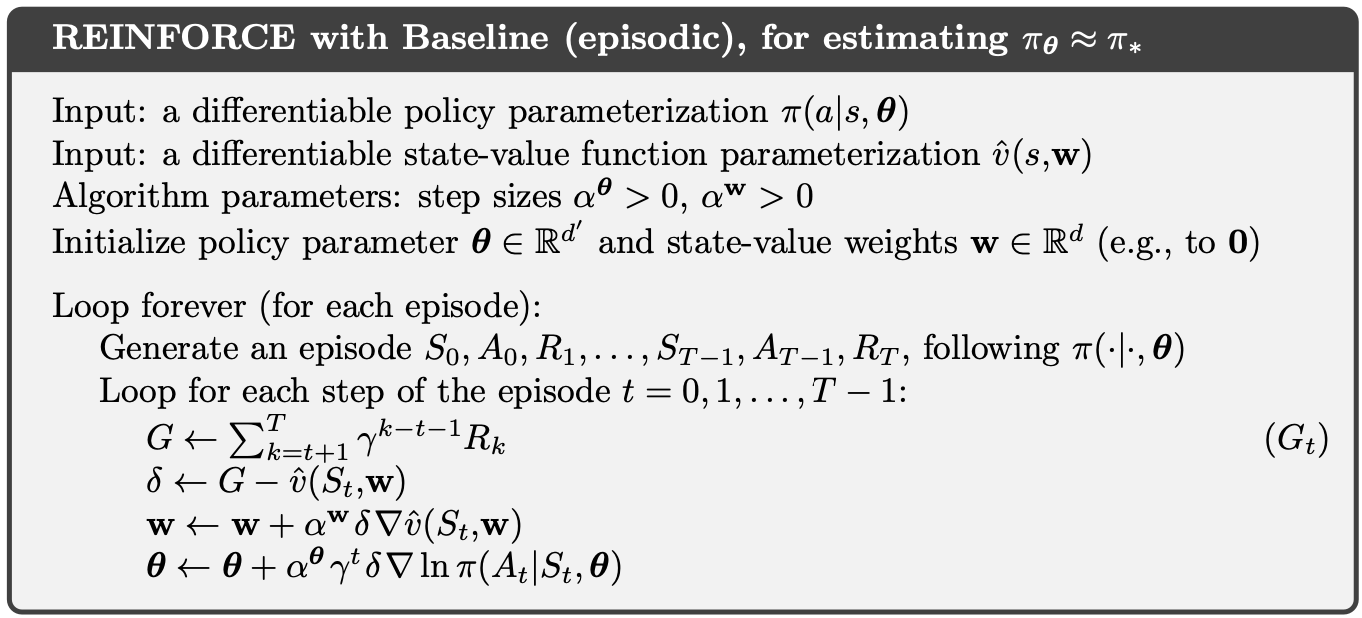


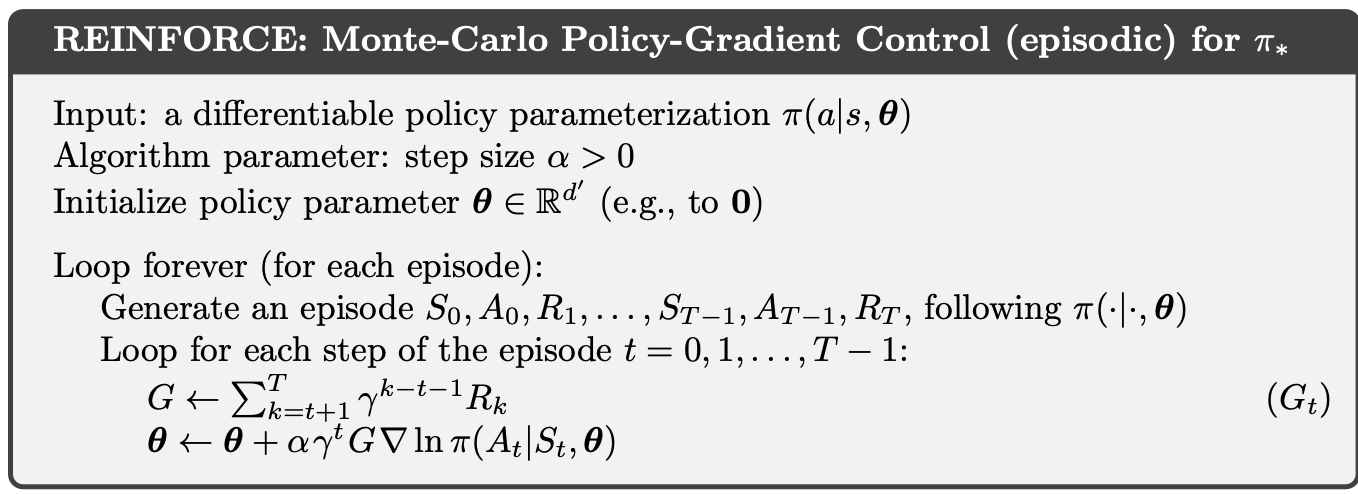

In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [11]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

## Notation of the Code Below
The function names and variables are based off the notation from Sutton.

$x(s,a)$ = Feature Vectors

$h(s,a,\theta)=\theta^Tx(s,a)$


In [12]:
class TileCodingApprox:
    def __init__(self, stateSpaceLowBoundary, stateSpaceHighBoundary, nActions, learningRateTheta):
        assert len(stateSpaceLowBoundary) == len(stateSpaceHighBoundary)
        self._nDimensions = len(stateSpaceLowBoundary)

        self._totalTiles = 4096 # Use 4096 since it appears to be more computationally efficient, not sure why but will do more research on this
        self._nTilings = 16
        self._nTiles = 8
        self._iht = IHT(self._totalTiles)

        self._learningRateTheta = learningRateTheta
        self._learningRateWeights = 0.1 / self._nTilings

        self._theta = np.zeros(self._totalTiles*nActions)
        # Purpose of setting these to 1 is because at the start, there's no reason to not be accelerating, so we will motivate the choices of accelerating and deaccelerating more
        self._theta[0:self._totalTiles] = 1
        self._theta[self._totalTiles*2:] = 1
        
        self._weights = np.zeros(self._totalTiles)
        
        self._nActions = nActions

        # These values are retrieved from the openAI environment
        self._minPosition = -1.2
        self._maxPosition = 0.5
        self._minVelocity = -0.07
        self._maxVelocity = 0.07

    def getTiles(self, state):
        position, velocity = state[0], state[1]
        positionScale = self._nTiles / (self._maxPosition - self._minPosition)
        velocityScale = self._nTiles / (self._maxVelocity - self._minVelocity)
        tiles1 = tiles(self._iht, self._nTilings, [position*positionScale, velocity*velocityScale])
        return tiles1

    def getActiveStateFeatures(self, state):
        activeTiles = self.getTiles(state)
        activeFeatures = np.zeros(self._totalTiles)
        activeFeatures[activeTiles] = 1
        return activeFeatures
    
    def getStateValue(self, state):
        return np.dot(self._weights, self.getActiveStateFeatures(state))
    
    def x(self, state, action):
        activeTiles = self.getTiles(state)
        featureVector = np.zeros(self._totalTiles)
        featureVector[activeTiles] = 1

        featureVectorScaled = np.zeros(self._totalTiles*self._nActions)
        featureVectorScaled[self._totalTiles*action:self._totalTiles*(action+1)] = featureVector
        return featureVectorScaled

    def h(self, state, action): 
        # Calculating the Preference h(s,a,theta)
        preference = np.dot(self._theta, self.x(state, action))
        return preference

    def softmax(self, x):
        # For some reason doing this doesn't work and cause values to become large. Had to utilize this long way 
        # ex = np.exp(x-np.max(x))
        # return ex / np.sum(ex)
        x = np.array(x)
        maxVal = np.max(x)
        x = x - maxVal
        expVal = np.exp(x)
        sumExpVal = np.sum(expVal)
        return expVal / sumExpVal
    
    def policy(self, state):
        hVector = [self.h(state, action) for action in range(self._nActions)]
        policy = self.softmax(hVector)
        return policy
    
    def updateTheta(self, state, action, discountedReturn):
        activeFeature = self.x(state, action)
        probVector = self.policy(state)
        expectedFeature = [self.x(state, b) for b in range(self._nActions)]
        expectedFeature = np.dot(probVector, expectedFeature)
        gradient = activeFeature - expectedFeature
        self._theta += self._learningRateTheta * discountedReturn * gradient
    
    def updateWeights(self, state, discountedReturn):
        activeFeatures = self.getActiveStateFeatures(state)
        self._weights += self._learningRateWeights * discountedReturn * activeFeatures

## Policy

In [13]:
# Parameters
maxTimeStep = 500
env = gym.make("MountainCar-v0", max_episode_steps=200)
nActions = env.action_space.n 
alpha = 0.001
gamma = 1
maxEpisodes = 10000

# Input
tiles2 = TileCodingApprox(env.observation_space.low, env.observation_space.high, nActions, 3e-8)

rewards = []
# Initialization
for episode in range(maxEpisodes):
    initialState, _ = env.reset()
    initialAction = np.random.choice(nActions, p=tiles2.policy(initialState))

    done = False
    trajectory = []
    totalReward = 0
    currentStepOfEpisode = 0
    while not done:
        nextState, reward, done, _, _ = env.step(initialAction)

        reward += (abs(nextState[1])) # Made is to that the velocity of the current state increases the reward
        trajectory.append([initialState, initialAction, reward]) # Trajectory: [State, Action, Reward]
        totalReward += reward

        initialState = nextState
        initialAction = np.random.choice(nActions, p=tiles2.policy(nextState))

        currentStepOfEpisode += 1
        if currentStepOfEpisode == maxEpisodes:
            done = True
            reward = -maxEpisodes

    rewards.append(totalReward)

    if currentStepOfEpisode != maxEpisodes:
        for t in range(len(trajectory)):
            G = 0
            for k in range(t+1, len(trajectory)):
                G += (gamma**(k-t-1)) * trajectory[k][2]
            delta = G - tiles2.getStateValue(trajectory[t][0])
            tiles2.updateWeights(trajectory[t][0], delta)
            tiles2.updateTheta(trajectory[t][0],trajectory[t][1],(gamma**t)*delta)
    print("# of episode: {}, score: {}".format(episode, totalReward))

env.close()

/Users/jasonchen/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# of episode: 0, score: -9767.236673367093
# of episode: 1, score: -2833.918880504299
# of episode: 2, score: -3140.732158294061
# of episode: 3, score: -3725.0219194173133
# of episode: 4, score: -3504.705660200145
# of episode: 5, score: -9783.707636147592
# of episode: 6, score: -9369.690026273252
# of episode: 7, score: -9836.88941799386
# of episode: 8, score: -1708.670412050732
# of episode: 9, score: -9803.735967537414
# of episode: 10, score: -9758.972449798079
# of episode: 11, score: -5723.585553650834
# of episode: 12, score: -9831.530040446183
# of episode: 13, score: -9793.276124972992
# of episode: 14, score: -3966.769688112745
# of episode: 15, score: -9783.06406611135
# of episode: 16, score: -9778.939798287254
# of episode: 17, score: -2581.006515412675
# of episode: 18, score: -9781.641638925992
# of episode: 19, score: -6279.557959861191
# of episode: 20, score: -9795.340213793515
# of episode: 21, score: -1298.441886066359
# of episode: 22, score: -2457.211555260689

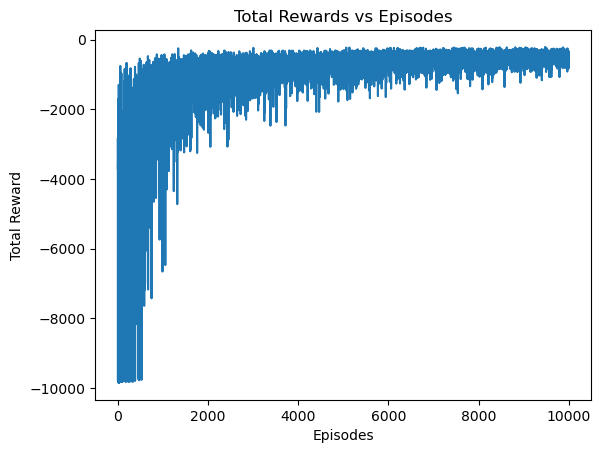

In [14]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Rewards vs Episodes')
plt.show()

## Summary

Comparing these results to the REINFORCE without baseline, it appears that this converged slower than the algorithm. However, this could be due to a couple of reasons:
1. I changed the theta step size higher
2. The policy being stochastic instead of deterministic

I do want to rerun this in the future, however this took around 4 hours to run on my laptop while the fan was running on blast. I would like to run this in the future, however I would probably need to run this on Google Colab. I did try running on Google Colab but due to the limited features that free users recieve it trained slower than if I trained it myself. However, I do hope to get a more powerful computer or Colab Pro+ in the future.